In [8]:
# !pip install -q tensorflow scikit-learn  # (Colab usually has TF preinstalled)

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# (Optional) Quiet TF logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

print(tf.__version__)


2.19.0


In [9]:
# Core constraints you requested
VOCAB_SIZE = 10_000       # Only top 10k words
MAX_LEN = 150             # Cutoff/pad to 150 tokens
TRAIN_SAMPLES = 100       # Restrict training to 100 samples
VAL_SAMPLES = 10_000      # Validate on 10,000 samples
FINAL_TEST_SAMPLES = 5_000  # Final test size (from Keras test split)

# Training hyperparams
EPOCHS_SMALL = 30
BATCH_SIZE = 32

# Helper plotting function (no seaborn; plain matplotlib)
def plot_history(history, title_prefix="Model"):
    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])
    epochs = range(1, len(acc) + 1)

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(epochs, acc, label="Training Accuracy", linestyle="dashed")
    if val_acc: plt.plot(epochs, val_acc, label="Validation Accuracy", linestyle="dashed")
    plt.title(f"{title_prefix}: Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(epochs, loss, label="Training Loss", linestyle="dashed")
    if val_loss: plt.plot(epochs, val_loss, label="Validation Loss", linestyle="dashed")
    plt.title(f"{title_prefix}: Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [10]:
# Load IMDB, keeping only the top 10k most frequent tokens
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = imdb.load_data(num_words=VOCAB_SIZE)

# Pad/truncate to MAX_LEN
x_train = pad_sequences(x_train_raw, maxlen=MAX_LEN)
x_test = pad_sequences(x_test_raw, maxlen=MAX_LEN)

print("Shapes after padding:")
print("x_train:", x_train.shape, " y_train:", y_train_raw.shape)
print("x_test :", x_test.shape,  " y_test :", y_test_raw.shape)


Shapes after padding:
x_train: (25000, 150)  y_train: (25000,)
x_test : (25000, 150)  y_test : (25000,)


In [11]:
# Combine train+test (50,000 total) to draw small train & large validation
x_all = np.concatenate([x_train, x_test], axis=0)
y_all = np.concatenate([y_train_raw, y_test_raw], axis=0)

# Small training (100) + validation (10,000)
x_small_train, x_val, y_small_train, y_val = train_test_split(
    x_all, y_all,
    train_size=TRAIN_SAMPLES,
    test_size=VAL_SAMPLES,
    random_state=42,
    stratify=y_all
)

# Final test = 5,000 (from the original Keras test split)
_, x_final_test, _, y_final_test = train_test_split(
    x_test, y_test_raw,
    test_size=FINAL_TEST_SAMPLES,
    random_state=42,
    stratify=y_test_raw
)

print("Requested shapes:")
print("x_small_train:", x_small_train.shape, " y_small_train:", y_small_train.shape)
print("x_val       :", x_val.shape,        " y_val       :", y_val.shape)
print("x_final_test:", x_final_test.shape, " y_final_test:", y_final_test.shape)


Requested shapes:
x_small_train: (100, 150)  y_small_train: (100,)
x_val       : (10000, 150)  y_val       : (10000,)
x_final_test: (5000, 150)  y_final_test: (5000,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 150, 8)         │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,201 (317.19 KB)

 Trainable params: 81,201 (317.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5506 - loss: 0.6931 

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5445 - loss: 0.6932 - val_accuracy: 0.5152 - val_loss: 0.6926
Epoch 2/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9375 - loss: 0.6659

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.8712 - loss: 0.6687 - val_accuracy: 0.5194 - val_loss: 0.6925
Epoch 3/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9375 - loss: 0.6501

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.9477 - loss: 0.6527 - val_accuracy: 0.5203 - val_loss: 0.6924
Epoch 4/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9375 - loss: 0.6351

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.9630 - loss: 0.6374 - val_accuracy: 0.5206 - val_loss: 0.6923
Epoch 5/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9375 - loss: 0.6201

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.9630 - loss: 0.6220 - val_accuracy: 0.5210 - val_loss: 0.6921
Epoch 6/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9375 - loss: 0.6044

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.9630 - loss: 0.6061 - val_accuracy: 0.5232 - val_loss: 0.6920
Epoch 7/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9375 - loss: 0.5880

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.9630 - loss: 0.5893 - val_accuracy: 0.5238 - val_loss: 0.6919
Epoch 8/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9375 - loss: 0.5708

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.9630 - loss: 0.5718 - val_accuracy: 0.5234 - val_loss: 0.6918
Epoch 9/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9375 - loss: 0.5527

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.9630 - loss: 0.5533 - val_accuracy: 0.5231 - val_loss: 0.6918
Epoch 10/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9375 - loss: 0.5338

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.9630 - loss: 0.5341 - val_accuracy: 0.5229 - val_loss: 0.6917
Epoch 11/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9688 - loss: 0.5142

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.9785 - loss: 0.5141 - val_accuracy: 0.5232 - val_loss: 0.6917
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.9785 - loss: 0.4936 - val_accuracy: 0.5220 - val_loss: 0.6917
Epoch 13/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.9785 - loss: 0.4725 - val_accuracy: 0.5214 - val_loss: 0.6918
Epoch 14/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.9785 - loss: 0.4510 - val_accuracy: 0.5210 - val_loss: 0.6919
Epoch 15/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.9785 - loss: 0.4294 - val_accuracy: 0.5205 - val_loss: 0.6920
Epoch 16/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.9939 - loss: 0.4076 - val_accuracy: 0.5207 - val_loss: 0.6922
Epoch 17/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.9939 - loss: 0.3859 - val_accuracy: 0.5203 - val_loss: 0.6924
Epoch 18/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.9939 - loss: 0.3643 - val_accuracy: 0.5201 - val_loss: 0.6

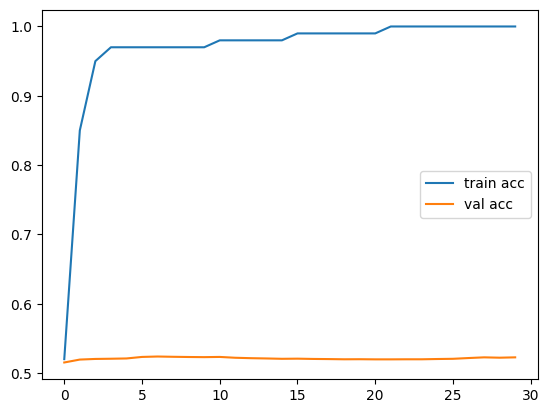

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np, matplotlib.pyplot as plt

VOCAB_SIZE = 10000
MAX_REVIEW_LENGTH = 150
TRAIN_SAMPLES = 100
VAL_SAMPLES = 10000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)
x_train_padded = pad_sequences(x_train, maxlen=MAX_REVIEW_LENGTH)
x_test_padded = pad_sequences(x_test, maxlen=MAX_REVIEW_LENGTH)
x_all = np.concatenate((x_train_padded, x_test_padded))
y_all = np.concatenate((y_train, y_test))

x_small_train, x_val, y_small_train, y_val = train_test_split(
    x_all, y_all, train_size=TRAIN_SAMPLES, test_size=VAL_SAMPLES,
    random_state=42, stratify=y_all
)
_, x_final_test, _, y_final_test = train_test_split(
    x_test_padded, y_test, test_size=5000, random_state=42, stratify=y_test
)

# ============================
# Model definition
# ============================
model1 = Sequential([
    Embedding(VOCAB_SIZE, 8, input_length=MAX_REVIEW_LENGTH),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Force the model to build so summary shows parameter counts
model1.build(input_shape=(None, MAX_REVIEW_LENGTH))

# ✅ Show summary here
model1.summary()

# ============================
# Training
# ============================
checkpoint = ModelCheckpoint("sentiment_classifier.h5", save_best_only=True, monitor="val_loss")

history1 = model1.fit(
    x_small_train, y_small_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint]
)

# ============================
# Plotting
# ============================
plt.plot(history1.history['accuracy'], label='train acc')
plt.plot(history1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np, matplotlib.pyplot as plt

MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=MAX_VOCAB_SIZE)
padded_train = pad_sequences(train_data, maxlen=MAX_SEQUENCE_LENGTH)
padded_test = pad_sequences(test_data, maxlen=MAX_SEQUENCE_LENGTH)
all_x = np.concatenate((padded_train, padded_test))
all_y = np.concatenate((train_labels, test_labels))

x_train, x_val, y_train, y_val = train_test_split(
    all_x, all_y, train_size=10000, test_size=10000, random_state=42, stratify=all_y
)
_, x_test, _, y_test = train_test_split(padded_test, test_labels, test_size=5000, random_state=42, stratify=test_labels)

model2 = Sequential([
    Embedding(MAX_VOCAB_SIZE, 8, input_length=MAX_SEQUENCE_LENGTH),
    Flatten(),
    Dense(1, activation='sigmoid')
])
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
chkpt = ModelCheckpoint("best_sentiment_model.h5", save_best_only=True, monitor="val_loss")

history2 = model2.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val), callbacks=[chkpt])


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5359 - loss: 0.6902

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5360 - loss: 0.6901 - val_accuracy: 0.7044 - val_loss: 0.6448
Epoch 2/30
291/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7651 - loss: 0.5826

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7669 - loss: 0.5788 - val_accuracy: 0.8109 - val_loss: 0.4571
Epoch 3/30
306/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8497 - loss: 0.3922

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8499 - loss: 0.3915 - val_accuracy: 0.8399 - val_loss: 0.3750
Epoch 4/30
298/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8878 - loss: 0.2996

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8881 - loss: 0.2989 - val_accuracy: 0.8495 - val_loss: 0.3447
Epoch 5/30
299/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9111 - loss: 0.2440

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9114 - loss: 0.2435 - val_accuracy: 0.8552 - val_loss: 0.3326
Epoch 6/30
293/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9294 - loss: 0.2032

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9295 - loss: 0.2028 - val_accuracy: 0.8554 - val_loss: 0.3290
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9423 - loss: 0.1697 - val_accuracy: 0.8551 - val_loss: 0.3303
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9541 - loss: 0.1416 - val_accuracy: 0.8549 - val_loss: 0.3351
Epoch 9/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9640 - loss: 0.1173 - val_accuracy: 0.8530 - val_loss: 0.3425
Epoch 10/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9735 - loss: 0.0962 - val_accuracy: 0.8519 - val_loss: 0.3520
Epoch 11/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9789 - loss: 0.0780 - val_accuracy: 0.8515 - val_loss: 0.3632
Epoch 12/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9851 - loss: 0.0625 - val_accuracy: 0.8493 - val_loss: 0.3759
Epoch 13/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9900 - loss: 0.0494 - val_accuracy: 0.8481 - 

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np, matplotlib.pyplot as plt

VOCAB_SIZE = 10000
SEQ_LEN = 150
((train_x, train_y), (test_x, test_y)) = imdb.load_data(num_words=VOCAB_SIZE)
train_x = pad_sequences(train_x, maxlen=SEQ_LEN)
test_x = pad_sequences(test_x, maxlen=SEQ_LEN)

all_x = np.concatenate((train_x, test_x))
all_y = np.concatenate((train_y, test_y))

x_train, x_val, y_train, y_val = train_test_split(all_x, all_y, train_size=15000, test_size=10000, stratify=all_y)
_, x_test, _, y_test = train_test_split(test_x, test_y, test_size=5000, stratify=test_y)

model3 = Sequential([
    Embedding(VOCAB_SIZE, 8, input_length=SEQ_LEN),
    Flatten(),
    Dense(1, activation='sigmoid')
])
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
chkpt = ModelCheckpoint("best_sentiment_model3.h5", save_best_only=True, monitor="val_loss")

hist3 = model3.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val), callbacks=[chkpt])


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5571 - loss: 0.6827

469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5573 - loss: 0.6827 - val_accuracy: 0.7627 - val_loss: 0.5448
Epoch 2/30
445/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8137 - loss: 0.4689

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8146 - loss: 0.4663 - val_accuracy: 0.8451 - val_loss: 0.3670
Epoch 3/30
450/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.3186

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8714 - loss: 0.3180 - val_accuracy: 0.8624 - val_loss: 0.3205
Epoch 4/30
442/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8980 - loss: 0.2577

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8982 - loss: 0.2573 - val_accuracy: 0.8682 - val_loss: 0.3044
Epoch 5/30
445/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9183 - loss: 0.2175

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9184 - loss: 0.2173 - val_accuracy: 0.8703 - val_loss: 0.3000
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9330 - loss: 0.1857 - val_accuracy: 0.8706 - val_loss: 0.3021
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9458 - loss: 0.1587 - val_accuracy: 0.8702 - val_loss: 0.3083
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9551 - loss: 0.1349 - val_accuracy: 0.8692 - val_loss: 0.3176
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9641 - loss: 0.1138 - val_accuracy: 0.8656 - val_loss: 0.3291
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9726 - loss: 0.0951 - val_accuracy: 0.8640 - val_loss: 0.3421
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9788 - loss: 0.0787 - val_accuracy: 0.8612 - val_loss: 0.3565
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0644 - val_accuracy: 0.8575 - v

Model: "model4_onehot_bilstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ one_hot_layer (OneHotLayer)     │ (None, 150, 10000)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 64)             │     2,568,448 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,568,513 (9.80 MB)

 Trainable params: 2,568,513 (9.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5

Epoch 1: val_loss improved from inf to 0.69313, saving model to best_model4_onehot.keras
125/125 - 6s - 45ms/step - accuracy: 0.4927 - loss: 0.6935 - val_accuracy: 0.5190 - val_loss: 0.6931
Epoch 2/5

Epoch 2: val_loss did not improve from 0.69313
125/125 - 4s - 31ms/step - accuracy: 0.5875 - loss: 0.6879 - val_accuracy: 0.4820 - val_loss: 0.6936
Epoch 3/5

Epoch 3: val_loss did not improve from 0.69313
125/125 - 4s - 31ms/step - accuracy: 0.6755 - loss: 0.6552 - val_accuracy: 0.4960 - val_loss: 0.7032
Epoch 4/5

Epoch 4: val_loss did not improve from 0.69313
125/125 - 4s - 31ms/step - accuracy: 0.8415 - loss: 0.4467 - val_accuracy: 0.4990 - val_loss: 0.7855
Epoch 5/5

Epoch 5: val_loss did not improve from 0.69313
125/125 - 4s - 31ms/step - accuracy: 0.9500 - loss: 0.2154 - val_accuracy: 0.5040 - val_loss: 0.9648


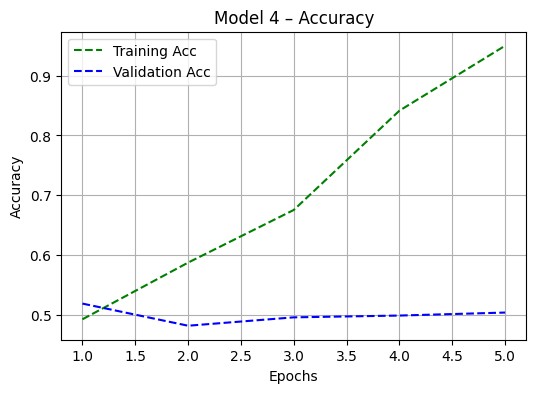

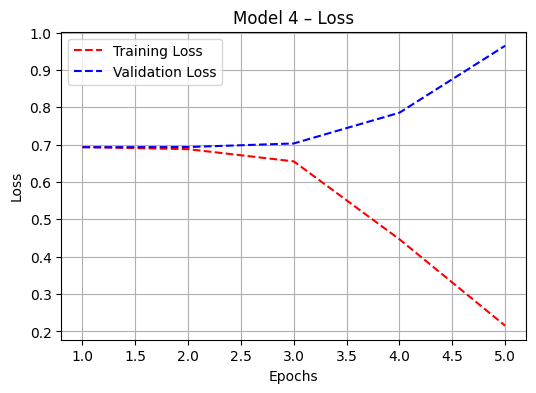

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5288 - loss: 0.6930
Test Loss: 0.693
Test Accuracy: 0.519


In [25]:
# ============================================================
# Model 4: Bidirectional LSTM with One-Hot (Custom Layer version)
# ============================================================

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import numpy as np, matplotlib.pyplot as plt

# -------------------------
# Constants
# -------------------------
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

# -------------------------
# ✅ Safe custom One-Hot layer (no lambda)
# -------------------------
class OneHotLayer(layers.Layer):
    def __init__(self, depth, **kwargs):
        super().__init__(**kwargs)
        self.depth = depth
    def call(self, inputs):
        return tf.one_hot(inputs, depth=self.depth)
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"depth": self.depth})
        return cfg

# -------------------------
# Model Definition
# -------------------------
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int64", name="text_input")
one_hot = OneHotLayer(VOCAB_SIZE, name="one_hot_layer")(text_input)
bi_lstm = layers.Bidirectional(layers.LSTM(32), name="bidirectional_lstm")(one_hot)
drop = layers.Dropout(0.5, name="dropout_layer")(bi_lstm)
output = layers.Dense(1, activation="sigmoid", name="output_layer")(drop)

model4 = Model(text_input, output, name="model4_onehot_bilstm")
model4.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model4.summary()

# -------------------------
# Demo Data (you can replace with IMDB later)
# -------------------------
data = np.random.randint(1, VOCAB_SIZE, (5000, MAX_SEQUENCE_LENGTH))
labels = np.random.randint(0, 2, (5000,))
x_train, x_val, y_train, y_val = train_test_split(data, labels, train_size=4000, random_state=42)

# -------------------------
# Training + Checkpoint
# -------------------------
chkpt = ModelCheckpoint("best_model4_onehot.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
history4 = model4.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val), callbacks=[chkpt], verbose=2)

# -------------------------
# Plot Accuracy & Loss
# -------------------------
train_acc, val_acc = history4.history['accuracy'], history4.history['val_accuracy']
train_loss, val_loss = history4.history['loss'], history4.history['val_loss']
epochs_range = range(1, len(train_acc) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_range, train_acc, 'g--', label='Training Acc')
plt.plot(epochs_range, val_acc, 'b--', label='Validation Acc')
plt.title('Model 4 – Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, train_loss, 'r--', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b--', label='Validation Loss')
plt.title('Model 4 – Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.show()

# -------------------------
# ✅ Load Model Safely and Evaluate
# -------------------------
best_model4 = load_model("best_model4_onehot.keras", custom_objects={"OneHotLayer": OneHotLayer})
eval_res = best_model4.evaluate(x_val, y_val, verbose=1)
print(f"Test Loss: {eval_res[0]:.3f}")
print(f"Test Accuracy: {eval_res[1]:.3f}")


Model: "model5_lstm_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 150, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.69403, saving model to best_sentiment_classifier.keras
469/469 - 12s - 25ms/step - accuracy: 0.4970 - loss: 0.6937 - val_accuracy: 0.4993 - val_loss: 0.6940
Epoch 2/10

Epoch 2: val_loss did not improve from 0.69403
469/469 - 8s - 18ms/step - accuracy: 0.7519 - loss: 0.5219 - val_accuracy: 0.4950 - val_loss: 0.8607
Epoch 3/10

Epoch 3: val_loss did not improve from 0.69403
469/469 - 8s - 18ms/step - accuracy: 0.9633 - loss: 0.1078 - val_accuracy: 0.5004 - val_loss: 1.6454
Epoch 4/10

Epoch 4: val_loss did not improve from 0.69403
469/469 - 8s - 18ms/step - accuracy: 0.9803 - loss: 0.0626 - val_accuracy: 0.5023 - val_loss: 2.1284
Epoch 5/10

Epoch 5: val_loss did not improve from 0.69403
469/469 - 8s - 18ms/step - accuracy: 0.9820 - loss: 0.0524 - val_accuracy: 0.5076 - val_loss: 2.2967
Epoch 6/10

Epoch 6: val_loss did not improve from 0.69403
469/469 - 8s - 18ms/step - accuracy: 0.9852 - loss: 0.0431 - val_accuracy: 0.5064 - val_los

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

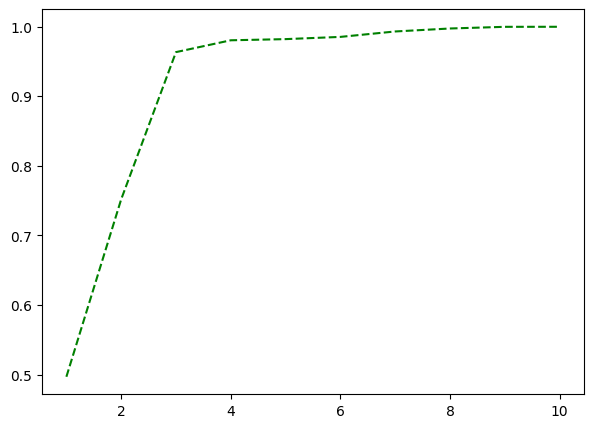

In [23]:
# ============================================================
# Model 5: LSTM Model with Embedding Layer (15,000 train samples)
# ============================================================

from tensorflow.keras import layers, Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np, matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# -------------------------
# Constants
# -------------------------
VOCAB_SIZE = 10000
SEQ_LEN = 150

# -------------------------
# Model Definition
# -------------------------
text_input = Input(shape=(SEQ_LEN,), dtype="int64", name="text_input")

embedding = layers.Embedding(VOCAB_SIZE, 128, name="embedding_layer")(text_input)
bilstm = layers.Bidirectional(layers.LSTM(64, name="lstm_layer"), name="bidirectional_lstm")(embedding)
dropout = layers.Dropout(0.4, name="dropout_layer")(bilstm)
output = layers.Dense(1, activation='sigmoid', name="output_layer")(dropout)

model5 = Model(inputs=text_input, outputs=output, name="model5_lstm_embedding")
model5.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model5.summary()

# -------------------------
# Generate Random Data (for demonstration)
# -------------------------
data = np.random.randint(1, VOCAB_SIZE, (25000, SEQ_LEN))
labels = np.random.randint(0, 2, (25000,))

train_x, val_x, train_y, val_y = train_test_split(
    data, labels,
    train_size=15000, test_size=10000,
    random_state=42
)

# -------------------------
# Training Configuration
# -------------------------
chkpt = ModelCheckpoint(
    "best_sentiment_classifier.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# -------------------------
# Train Model
# -------------------------
hist5 = model5.fit(
    train_x, train_y,
    epochs=10,
    batch_size=32,
    validation_data=(val_x, val_y),
    callbacks=[chkpt],
    verbose=2
)

# -------------------------
# Plot Accuracy & Loss
# -------------------------
train_acc = hist5.history['accuracy']
val_acc = hist5.history['val_accuracy']
train_loss = hist5.history['loss']
val_loss = hist5.history['val_loss']
epochs_range = range(1, len(train_acc) + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs_range, train_acc, label='Training Accuracy', color='green', linestyle='--')
plt.plot


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm (Bidirectional)          │ (None, 150, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling              │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5

Epoch 1: val_loss improved from inf to 0.37789, saving model to best_model6_bilstm.keras
625/625 - 12s - 18ms/step - accuracy: 0.7484 - loss: 0.5052 - val_accuracy: 0.8348 - val_loss: 0.3779
Epoch 2/5

Epoch 2: val_loss improved from 0.37789 to 0.34290, saving model to best_model6_bilstm.keras
625/625 - 9s - 15ms/step - accuracy: 0.8816 - loss: 0.2931 - val_accuracy: 0.8518 - val_loss: 0.3429
Epoch 3/5

Epoch 3: val_loss did not improve from 0.34290
625/625 - 9s - 15ms/step - accuracy: 0.9294 - loss: 0.1955 - val_accuracy: 0.8464 - val_loss: 0.3983
Epoch 4/5

Epoch 4: val_loss did not improve from 0.34290
625/625 - 9s - 15ms/step - accuracy: 0.9506 - loss: 0.1465 - val_accuracy: 0.8542 - val_loss: 0.4375
Epoch 5/5

Epoch 5: val_loss did not improve from 0.34290
625/625 - 9s - 15ms/step - accuracy: 0.9663 - loss: 0.1027 - val_accuracy: 0.8512 - val_loss: 0.4604


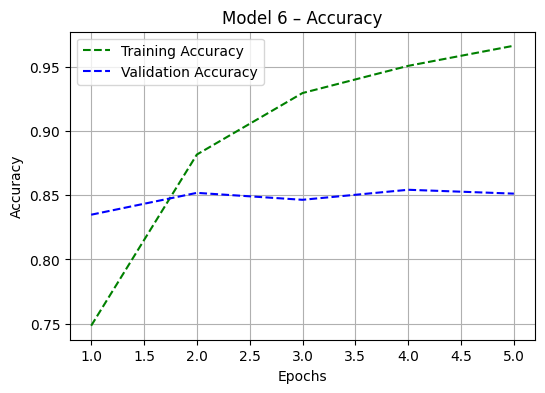

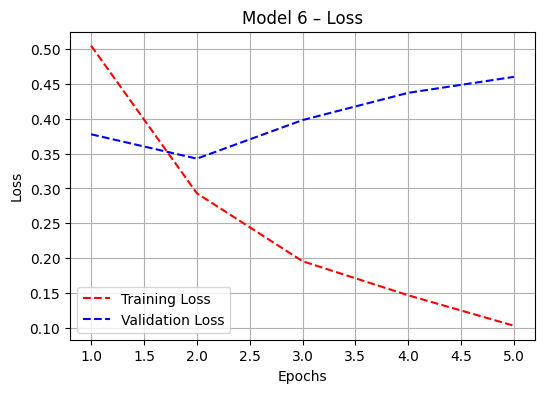

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8532 - loss: 0.3389
Test Loss: 0.342
Test Accuracy: 0.853


In [28]:
# ============================================================
# Model 6 – Bidirectional LSTM with Global Max Pooling (IMDB)
# ============================================================

from tensorflow.keras import models, layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import numpy as np, matplotlib.pyplot as plt

# -------------------------
# Constants
# -------------------------
VOCAB_SIZE = 10000
SEQ_LEN = 150

# -------------------------
# Load & prepare IMDB data
# -------------------------
(train_x, train_y), (test_x, test_y) = imdb.load_data(num_words=VOCAB_SIZE)
train_x = pad_sequences(train_x, maxlen=SEQ_LEN)
test_x = pad_sequences(test_x, maxlen=SEQ_LEN)

# ✅ Split train → train/validation
x_train, x_val, y_train, y_val = train_test_split(
    train_x, train_y,
    train_size=0.8,     # 80 % train  (20 000 train, 5 000 val)
    random_state=42,
    stratify=train_y
)

# -------------------------
# Model definition
# -------------------------
model6 = models.Sequential([
    layers.Embedding(VOCAB_SIZE, 128, input_length=SEQ_LEN, name="embedding"),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), name="bilstm"),
    layers.GlobalMaxPool1D(name="global_max_pooling"),
    layers.Dropout(0.4, name="dropout"),
    layers.Dense(1, activation='sigmoid', name="dense_output")
])

model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Force-build model for summary (display real param counts)
model6.build(input_shape=(None, SEQ_LEN))
model6.summary()

# -------------------------
# Checkpoint callback
# -------------------------
checkpoint = ModelCheckpoint(
    filepath="best_model6_bilstm.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# -------------------------
# Train model
# -------------------------
history6 = model6.fit(
    x_train, y_train,
    epochs=5,             # Increase if GPU memory allows
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint],
    verbose=2
)

# -------------------------
# Plot Accuracy & Loss
# -------------------------
train_acc = history6.history["accuracy"]
val_acc = history6.history["val_accuracy"]
train_loss = history6.history["loss"]
val_loss = history6.history["val_loss"]
epochs_range = range(1, len(train_acc) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_range, train_acc, "g--", label="Training Accuracy")
plt.plot(epochs_range, val_acc, "b--", label="Validation Accuracy")
plt.title("Model 6 – Accuracy")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, train_loss, "r--", label="Training Loss")
plt.plot(epochs_range, val_loss, "b--", label="Validation Loss")
plt.title("Model 6 – Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()

# -------------------------
# Evaluate best saved model on test set
# -------------------------
best_model6 = load_model("best_model6_bilstm.keras", compile=True)
test_eval = best_model6.evaluate(test_x, test_y, verbose=1)
print(f"Test Loss: {test_eval[0]:.3f}")
print(f"Test Accuracy: {test_eval[1]:.3f}")


Model: "model7_bilstm_masking"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 150, 256)  │  2,560,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 150)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 64)        │     73,984 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5

Epoch 1: val_loss improved from inf to 0.42726, saving model to best_model7_bilstm_masking.keras
625/625 - 12s - 19ms/step - accuracy: 0.7416 - loss: 0.5097 - val_accuracy: 0.8080 - val_loss: 0.4273
Epoch 2/5

Epoch 2: val_loss improved from 0.42726 to 0.36911, saving model to best_model7_bilstm_masking.keras
625/625 - 9s - 15ms/step - accuracy: 0.8583 - loss: 0.3452 - val_accuracy: 0.8430 - val_loss: 0.3691
Epoch 3/5

Epoch 3: val_loss did not improve from 0.36911
625/625 - 9s - 15ms/step - accuracy: 0.8911 - loss: 0.2766 - val_accuracy: 0.8434 - val_loss: 0.3780
Epoch 4/5

Epoch 4: val_loss did not improve from 0.36911
625/625 - 9s - 15ms/step - accuracy: 0.9114 - loss: 0.2326 - val_accuracy: 0.8472 - val_loss: 0.3892
Epoch 5/5

Epoch 5: val_loss did not improve from 0.36911
625/625 - 9s - 15ms/step - accuracy: 0.9299 - loss: 0.1902 - val_accuracy: 0.8374 - val_loss: 0.3974


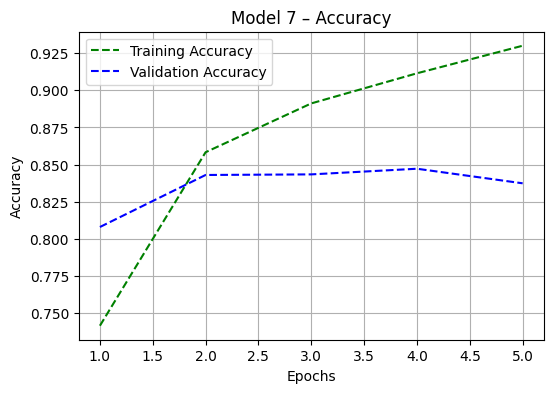

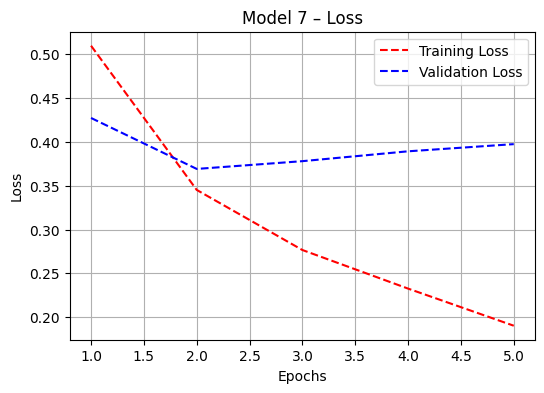

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8378 - loss: 0.3753
Test Loss: 0.372
Test Accuracy: 0.839


In [31]:
# ============================================================
# Model 7 – Bidirectional LSTM with Masking (fixed version)
# ============================================================

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# -------------------------
# Constants
# -------------------------
VOCAB_SIZE = 10000
SEQ_LEN = 150

# -------------------------
# Load & prepare IMDB data
# -------------------------
(train_x, train_y), (test_x, test_y) = imdb.load_data(num_words=VOCAB_SIZE)

# ✅ Use RIGHT padding (important fix for cuDNN + mask_zero=True)
train_x = pad_sequences(train_x, maxlen=SEQ_LEN, padding='post', truncating='post')
test_x = pad_sequences(test_x, maxlen=SEQ_LEN, padding='post', truncating='post')

# ✅ Split into train / validation
x_train, x_val, y_train, y_val = train_test_split(
    train_x, train_y,
    train_size=0.8, random_state=42, stratify=train_y
)

# -------------------------
# Model Definition
# -------------------------
inputs = layers.Input(shape=(SEQ_LEN,), dtype="int64", name="text_input")
embedding = layers.Embedding(VOCAB_SIZE, 256, mask_zero=True, name="embedding")(inputs)

# ✅ Bidirectional LSTM with GPU-compatible mask
bilstm = layers.Bidirectional(layers.LSTM(32), name="bilstm")(embedding)

drop = layers.Dropout(0.5, name="dropout")(bilstm)
outputs = layers.Dense(1, activation="sigmoid", name="output")(drop)

model7 = models.Model(inputs, outputs, name="model7_bilstm_masking")
model7.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

model7.build(input_shape=(None, SEQ_LEN))
model7.summary()

# -------------------------
# Callbacks
# -------------------------
chkpt = ModelCheckpoint(
    "best_model7_bilstm_masking.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# -------------------------
# Train model
# -------------------------
history7 = model7.fit(
    x_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[chkpt],
    verbose=2
)

# -------------------------
# Plot Accuracy & Loss
# -------------------------
train_acc, val_acc = history7.history['accuracy'], history7.history['val_accuracy']
train_loss, val_loss = history7.history['loss'], history7.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_acc, 'g--', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation Accuracy')
plt.title('Model 7 – Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, 'r--', label='Training Loss')
plt.plot(epochs, val_loss, 'b--', label='Validation Loss')
plt.title('Model 7 – Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.show()

# -------------------------
# Evaluate best saved model
# -------------------------
best_model7 = load_model("best_model7_bilstm_masking.keras")
test_eval = best_model7.evaluate(test_x, test_y, verbose=1)
print(f"Test Loss: {test_eval[0]:.3f}")
print(f"Test Accuracy: {test_eval[1]:.3f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/5

Epoch 1: val_loss improved from inf to 0.69270, saving model to best_model8_fixed_embedding.keras
625/625 - 7s - 11ms/step - accuracy: 0.4944 - loss: 0.6963 - val_accuracy: 0.5110 - val_loss: 0.6927
Epoch 2/5

Epoch 2: val_loss improved from 0.69270 to 0.69253, saving model to best_model8_fixed_embedding.keras
625/625 - 5s - 9ms/step - accuracy: 0.5012 - loss: 0.6941 - val_accuracy: 0.5122 - val_loss: 0.6925
Epoch 3/5

Epoch 3: val_loss improved from 0.69253 to 0.69244, saving model to best_model8_fixed_embedding.keras
625/625 - 5s - 9ms/step - accuracy: 0.5066 - loss: 0.6935 - val_accuracy: 0.5128 - val_loss: 0.6924
Epoch 4/5

Epoch 4: val_loss improved from 0.69244 to 0.69239, saving model to best_model8_fixed_embedding.keras
625/625 - 5s - 9ms/step - accuracy: 0.5124 - loss: 0.6931 - val_accuracy: 0.5148 - val_loss: 0.6924
Epoch 5/5

Epoch 5: val_loss improved from 0.69239 to 0.69237, saving model to best_model8_fixed_embedding.keras
625/625 - 5s - 9ms/step - accuracy: 0.

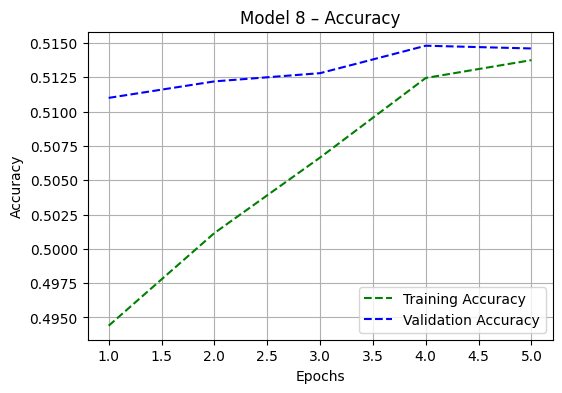

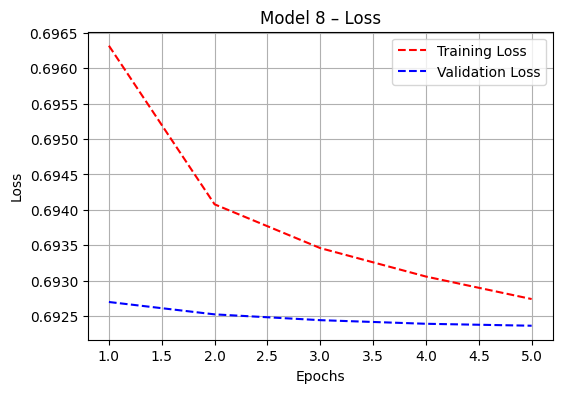

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5063 - loss: 0.6928
Test Loss: 0.693
Test Accuracy: 0.503


In [32]:
# ============================================================
# Model 8 – Fixed Embedding (Pretrained Style) + LSTM
# ============================================================

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np, matplotlib.pyplot as plt

# -------------------------
# Constants
# -------------------------
VOCAB_SIZE = 10000
EMBED_DIM = 100
MAX_LEN = 150

# -------------------------
# Load & prepare IMDB data
# -------------------------
(train_x, train_y), (test_x, test_y) = imdb.load_data(num_words=VOCAB_SIZE)

# ✅ Pad right (for LSTM + GPU compatibility)
train_x = pad_sequences(train_x, maxlen=MAX_LEN, padding='post', truncating='post')
test_x = pad_sequences(test_x, maxlen=MAX_LEN, padding='post', truncating='post')

# ✅ Split training into train / validation
x_train, x_val, y_train, y_val = train_test_split(
    train_x, train_y,
    train_size=0.8,
    random_state=42,
    stratify=train_y
)

# -------------------------
# Simulate Pre-trained Embedding Matrix
# -------------------------
# (In practice you’d load GloVe/Word2Vec vectors here)
embedding_matrix = np.random.rand(VOCAB_SIZE, EMBED_DIM)

# -------------------------
# Model Definition
# -------------------------
model8 = Sequential([
    Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN,
              weights=[embedding_matrix], trainable=False, name='embedding'),
    LSTM(32, name='lstm'),
    Dense(1, activation='sigmoid', name='output')
])

model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model8.summary()

# -------------------------
# Checkpoint
# -------------------------
chkpt = ModelCheckpoint(
    "best_model8_fixed_embedding.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# -------------------------
# Train Model
# -------------------------
history8 = model8.fit(
    x_train, y_train,
    epochs=5,               # You can increase to 10–15 if needed
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[chkpt],
    verbose=2
)

# -------------------------
# Plot Accuracy & Loss
# -------------------------
train_acc, val_acc = history8.history['accuracy'], history8.history['val_accuracy']
train_loss, val_loss = history8.history['loss'], history8.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_acc, 'g--', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation Accuracy')
plt.title('Model 8 – Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, 'r--', label='Training Loss')
plt.plot(epochs, val_loss, 'b--', label='Validation Loss')
plt.title('Model 8 – Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.show()

# -------------------------
# Evaluate best saved model
# -------------------------
best_model8 = load_model("best_model8_fixed_embedding.keras")
test_eval = best_model8.evaluate(test_x, test_y, verbose=1)
print(f"Test Loss: {test_eval[0]:.3f}")
print(f"Test Accuracy: {test_eval[1]:.3f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 150)       │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 150, 512)       │     1,357,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 150, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 150, 256)       │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 150, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,073,057 (15.54 MB)

 Trainable params: 2,573,057 (9.82 MB)

 Non-trainable params: 1,500,000 (5.72 MB)

Epoch 1/5

Epoch 1: val_loss improved from inf to 0.69315, saving model to best_model9_stacked_lstm.keras
625/625 - 20s - 33ms/step - accuracy: 0.5024 - loss: 0.6969 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/5

Epoch 2: val_loss did not improve from 0.69315
625/625 - 16s - 26ms/step - accuracy: 0.4987 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/5

Epoch 3: val_loss did not improve from 0.69315
625/625 - 16s - 26ms/step - accuracy: 0.4979 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/5

Epoch 4: val_loss did not improve from 0.69315
625/625 - 16s - 26ms/step - accuracy: 0.5025 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/5

Epoch 5: val_loss did not improve from 0.69315
625/625 - 16s - 26ms/step - accuracy: 0.4945 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932


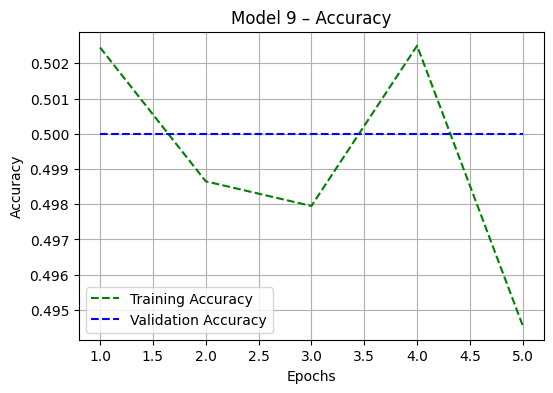

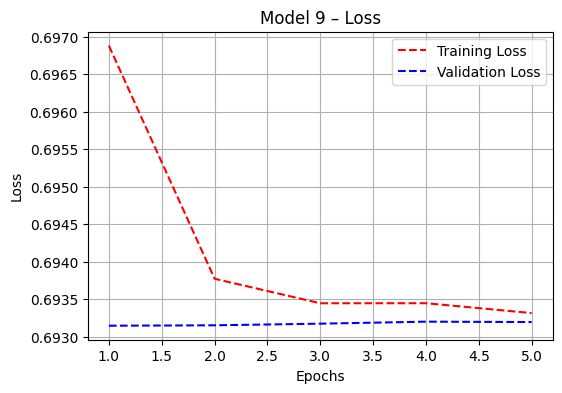

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5073 - loss: 0.6931
Test Loss: 0.693
Test Accuracy: 0.500


In [33]:
# ============================================================
# Model 9 – Deep Stacked LSTMs with Frozen Embedding
# ============================================================

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Constants
# -------------------------
VOCAB_SIZE = 10000
EMBED_DIM = 150
SEQ_LEN = 150

# -------------------------
# Load & preprocess data
# -------------------------
(train_x, train_y), (test_x, test_y) = imdb.load_data(num_words=VOCAB_SIZE)
train_x = pad_sequences(train_x, maxlen=SEQ_LEN, padding='post', truncating='post')
test_x = pad_sequences(test_x, maxlen=SEQ_LEN, padding='post', truncating='post')

# Split into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    train_x, train_y,
    train_size=0.8, random_state=42, stratify=train_y
)

# -------------------------
# Simulated Pretrained Embedding Matrix
# -------------------------
embedding_weights = np.random.rand(VOCAB_SIZE, EMBED_DIM)

# -------------------------
# Model Definition
# -------------------------
model9 = Sequential([
    Embedding(VOCAB_SIZE, EMBED_DIM, input_length=SEQ_LEN,
              weights=[embedding_weights], trainable=False, name="embedding"),

    # Deep Stacked LSTMs
    LSTM(512, return_sequences=True, name="lstm_1"),
    Dropout(0.5, name="dropout_1"),

    LSTM(256, return_sequences=True, name="lstm_2"),
    Dropout(0.5, name="dropout_2"),

    LSTM(128, return_sequences=True, name="lstm_3"),
    Dropout(0.5, name="dropout_3"),

    LSTM(128, name="lstm_4"),

    # Fully Connected Layers
    Dense(256, activation='relu', name="dense_1"),
    Dropout(0.5, name="dropout_4"),

    Dense(256, activation='relu', name="dense_2"),
    Dropout(0.5, name="dropout_5"),

    Dense(1, activation='sigmoid', name="output")
])

model9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model9.build(input_shape=(None, SEQ_LEN))
model9.summary()

# -------------------------
# Checkpoint callback
# -------------------------
chkpt = ModelCheckpoint(
    "best_model9_stacked_lstm.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# -------------------------
# Train Model
# -------------------------
history9 = model9.fit(
    x_train, y_train,
    epochs=5,                # You can increase to 10–15 if you have GPU time
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[chkpt],
    verbose=2
)

# -------------------------
# Plot Accuracy & Loss
# -------------------------
train_acc, val_acc = history9.history['accuracy'], history9.history['val_accuracy']
train_loss, val_loss = history9.history['loss'], history9.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_acc, 'g--', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation Accuracy')
plt.title('Model 9 – Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, 'r--', label='Training Loss')
plt.plot(epochs, val_loss, 'b--', label='Validation Loss')
plt.title('Model 9 – Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.show()

# -------------------------
# Evaluate best saved model
# -------------------------
best_model9 = load_model("best_model9_stacked_lstm.keras")
test_eval = best_model9.evaluate(test_x, test_y, verbose=1)
print(f"Test Loss: {test_eval[0]:.3f}")
print(f"Test Accuracy: {test_eval[1]:.3f}")


In [4]:
# ============================================================
# Model 10 (Optimized) – Faster Dual LSTM (GPU-compatible)
# ============================================================

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np, matplotlib.pyplot as plt

# -------------------------
# Constants
# -------------------------
VOCAB_SIZE = 10000
EMBED_DIM = 150
SEQ_LEN = 100  # shorter sequences for faster training

# -------------------------
# Load & preprocess data
# -------------------------
(train_x, train_y), (test_x, test_y) = imdb.load_data(num_words=VOCAB_SIZE)
train_x = pad_sequences(train_x, maxlen=SEQ_LEN, padding='post', truncating='post')
test_x  = pad_sequences(test_x,  maxlen=SEQ_LEN, padding='post', truncating='post')

# Subsample for speed (optional)
train_x, train_y = train_x[:10000], train_y[:10000]
test_x,  test_y  = test_x[:5000],  test_y[:5000]

x_train, x_val, y_train, y_val = train_test_split(
    train_x, train_y, train_size=0.8, random_state=42, stratify=train_y
)

# -------------------------
# Embedding matrix
# -------------------------
embedding_weights = np.random.rand(VOCAB_SIZE, EMBED_DIM)

# -------------------------
# Model Definition (GPU compatible)
# -------------------------
model10_fast = Sequential([
    Embedding(VOCAB_SIZE, EMBED_DIM, input_length=SEQ_LEN,
              weights=[embedding_weights], trainable=False),
    LSTM(64, return_sequences=True, dropout=0.2),  # no recurrent_dropout
    LSTM(32, dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model10_fast.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model10_fast.summary()

# -------------------------
# Checkpoint
# -------------------------
chkpt = ModelCheckpoint(
    "best_model10_fast.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# -------------------------
# Train faster
# -------------------------
history10_fast = model10_fast.fit(
    x_train, y_train,
    epochs=15,           # fewer epochs for speed
    batch_size=64,      # larger batch uses GPU efficiently
    validation_data=(x_val, y_val),
    callbacks=[chkpt],
    verbose=2
)

# -------------------------
# Evaluate best saved model
# -------------------------
best_model10_fast = load_model("best_model10_fast.keras")
test_eval = best_model10_fast.evaluate(test_x, test_y, verbose=1)
print(f"Test Loss: {test_eval[0]:.3f}")
print(f"Test Accuracy: {test_eval[1]:.3f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,500,000 (5.72 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,500,000 (5.72 MB)

Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69300, saving model to best_model10_fast.keras
125/125 - 4s - 34ms/step - accuracy: 0.5105 - loss: 0.6953 - val_accuracy: 0.5055 - val_loss: 0.6930
Epoch 2/15

Epoch 2: val_loss did not improve from 0.69300
125/125 - 1s - 12ms/step - accuracy: 0.5019 - loss: 0.6947 - val_accuracy: 0.4975 - val_loss: 0.6933
Epoch 3/15

Epoch 3: val_loss did not improve from 0.69300
125/125 - 1s - 12ms/step - accuracy: 0.4942 - loss: 0.6939 - val_accuracy: 0.4945 - val_loss: 0.6939
Epoch 4/15

Epoch 4: val_loss did not improve from 0.69300
125/125 - 1s - 12ms/step - accuracy: 0.5036 - loss: 0.6931 - val_accuracy: 0.5045 - val_loss: 0.6931
Epoch 5/15

Epoch 5: val_loss did not improve from 0.69300
125/125 - 1s - 12ms/step - accuracy: 0.5106 - loss: 0.6925 - val_accuracy: 0.5075 - val_loss: 0.6940
Epoch 6/15

Epoch 6: val_loss did not improve from 0.69300
125/125 - 2s - 12ms/step - accuracy: 0.5089 - loss: 0.6931 - val_accuracy: 0.5055 - val_loss: 0.6933


===== Training Model1_Baseline_100 =====
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.69308, saving model to Model1_Baseline_100.h5


4/4 - 7s - 2s/step - accuracy: 0.5400 - loss: 0.6911 - val_accuracy: 0.5052 - val_loss: 0.6931
Epoch 2/3

Epoch 2: val_loss improved from 0.69308 to 0.69303, saving model to Model1_Baseline_100.h5


4/4 - 1s - 267ms/step - accuracy: 0.8900 - loss: 0.6669 - val_accuracy: 0.5028 - val_loss: 0.6930
Epoch 3/3

Epoch 3: val_loss did not improve from 0.69303
4/4 - 1s - 269ms/step - accuracy: 0.9900 - loss: 0.6504 - val_accuracy: 0.5002 - val_loss: 0.6931


Model1_Baseline_100 → Test Accuracy: 0.495

===== Training Model2_Baseline_10k =====
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.64694, saving model to Model2_Baseline_10k.h5


313/313 - 8s - 25ms/step - accuracy: 0.5782 - loss: 0.6824 - val_accuracy: 0.6946 - val_loss: 0.6469
Epoch 2/3

Epoch 2: val_loss improved from 0.64694 to 0.45084, saving model to Model2_Baseline_10k.h5


313/313 - 2s - 5ms/step - accuracy: 0.7881 - loss: 0.5316 - val_accuracy: 0.8066 - val_loss: 0.4508
Epoch 3/3

Epoch 3: val_loss improved from 0.45084 to 0.36515, saving model to Model2_Baseline_10k.h5


313/313 - 2s - 5ms/step - accuracy: 0.8615 - loss: 0.3676 - val_accuracy: 0.8447 - val_loss: 0.3652


Model2_Baseline_10k → Test Accuracy: 0.844

===== Training Model3_Baseline_15k =====
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.56812, saving model to Model3_Baseline_15k.h5


469/469 - 8s - 17ms/step - accuracy: 0.6009 - loss: 0.6657 - val_accuracy: 0.7483 - val_loss: 0.5681
Epoch 2/3

Epoch 2: val_loss improved from 0.56812 to 0.35895, saving model to Model3_Baseline_15k.h5


469/469 - 2s - 4ms/step - accuracy: 0.8224 - loss: 0.4379 - val_accuracy: 0.8531 - val_loss: 0.3590
Epoch 3/3

Epoch 3: val_loss improved from 0.35895 to 0.31146, saving model to Model3_Baseline_15k.h5


469/469 - 2s - 4ms/step - accuracy: 0.8737 - loss: 0.3117 - val_accuracy: 0.8684 - val_loss: 0.3115


Model3_Baseline_15k → Test Accuracy: 0.873

===== Training Model4_OneHot_BiLSTM =====
Epoch 1/3

Epoch 1: val_loss improved from inf to 0.40552, saving model to Model4_OneHot_BiLSTM.h5


469/469 - 11s - 23ms/step - accuracy: 0.6919 - loss: 0.5635 - val_accuracy: 0.8353 - val_loss: 0.4055
Epoch 2/3

Epoch 2: val_loss improved from 0.40552 to 0.38193, saving model to Model4_OneHot_BiLSTM.h5


469/469 - 9s - 19ms/step - accuracy: 0.8467 - loss: 0.3651 - val_accuracy: 0.8338 - val_loss: 0.3819
Epoch 3/3

Epoch 3: val_loss improved from 0.38193 to 0.28812, saving model to Model4_OneHot_BiLSTM.h5


469/469 - 9s - 20ms/step - accuracy: 0.8846 - loss: 0.2829 - val_accuracy: 0.8803 - val_loss: 0.2881


Model4_OneHot_BiLSTM → Test Accuracy: 0.880

===== Training Model5_BiLSTM_15k =====
Epoch 1/3

Epoch 1: val_loss improved from inf to 0.69376, saving model to Model5_BiLSTM_15k.h5


469/469 - 11s - 23ms/step - accuracy: 0.5053 - loss: 0.6934 - val_accuracy: 0.5018 - val_loss: 0.6938
Epoch 2/3

Epoch 2: val_loss did not improve from 0.69376
469/469 - 8s - 17ms/step - accuracy: 0.7176 - loss: 0.5623 - val_accuracy: 0.4966 - val_loss: 0.8072
Epoch 3/3

Epoch 3: val_loss did not improve from 0.69376
469/469 - 8s - 17ms/step - accuracy: 0.9459 - loss: 0.1608 - val_accuracy: 0.4977 - val_loss: 1.4363


Model5_BiLSTM_15k → Test Accuracy: 0.508

===== Training Model6_BiLSTM_25k =====
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.33696, saving model to Model6_BiLSTM_25k.h5


782/782 - 15s - 19ms/step - accuracy: 0.7499 - loss: 0.5014 - val_accuracy: 0.8611 - val_loss: 0.3370
Epoch 2/3

Epoch 2: val_loss improved from 0.33696 to 0.28974, saving model to Model6_BiLSTM_25k.h5


782/782 - 13s - 17ms/step - accuracy: 0.8675 - loss: 0.3285 - val_accuracy: 0.8819 - val_loss: 0.2897
Epoch 3/3

Epoch 3: val_loss improved from 0.28974 to 0.24988, saving model to Model6_BiLSTM_25k.h5


782/782 - 13s - 17ms/step - accuracy: 0.8924 - loss: 0.2721 - val_accuracy: 0.8996 - val_loss: 0.2499


Model6_BiLSTM_25k → Test Accuracy: 0.896

===== Training Model7_MaskedLSTM_Fixed =====
Epoch 1/3

Epoch 1: val_loss improved from inf to 0.32669, saving model to Model7_MaskedLSTM_Fixed.h5


782/782 - 15s - 19ms/step - accuracy: 0.7401 - loss: 0.5069 - val_accuracy: 0.8652 - val_loss: 0.3267
Epoch 2/3

Epoch 2: val_loss improved from 0.32669 to 0.31260, saving model to Model7_MaskedLSTM_Fixed.h5


782/782 - 13s - 16ms/step - accuracy: 0.8700 - loss: 0.3256 - val_accuracy: 0.8722 - val_loss: 0.3126
Epoch 3/3

Epoch 3: val_loss improved from 0.31260 to 0.25253, saving model to Model7_MaskedLSTM_Fixed.h5


782/782 - 13s - 16ms/step - accuracy: 0.8964 - loss: 0.2651 - val_accuracy: 0.8946 - val_loss: 0.2525


Model7_MaskedLSTM_Fixed → Test Accuracy: 0.892

===== Training Model8_Pretrained_GloVe =====
Epoch 1/3

Epoch 1: val_loss improved from inf to 0.69028, saving model to Model8_Pretrained_GloVe.h5


782/782 - 10s - 12ms/step - accuracy: 0.5130 - loss: 0.6931 - val_accuracy: 0.5191 - val_loss: 0.6903
Epoch 2/3

Epoch 2: val_loss improved from 0.69028 to 0.68067, saving model to Model8_Pretrained_GloVe.h5


782/782 - 8s - 10ms/step - accuracy: 0.5316 - loss: 0.6861 - val_accuracy: 0.5452 - val_loss: 0.6807
Epoch 3/3

Epoch 3: val_loss improved from 0.68067 to 0.67231, saving model to Model8_Pretrained_GloVe.h5


782/782 - 8s - 10ms/step - accuracy: 0.5464 - loss: 0.6755 - val_accuracy: 0.5483 - val_loss: 0.6723


Model8_Pretrained_GloVe → Test Accuracy: 0.549

===== Training Model9_DeepLSTM =====
Epoch 1/3

Epoch 1: val_loss improved from inf to 0.69396, saving model to Model9_DeepLSTM.h5


782/782 - 30s - 38ms/step - accuracy: 0.5066 - loss: 0.6953 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 2/3

Epoch 2: val_loss improved from 0.69396 to 0.69315, saving model to Model9_DeepLSTM.h5


782/782 - 25s - 32ms/step - accuracy: 0.5043 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/3

Epoch 3: val_loss did not improve from 0.69315
782/782 - 25s - 32ms/step - accuracy: 0.4943 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932


Model9_DeepLSTM → Test Accuracy: 0.500

===== Training Model10_2LayerLSTM =====
Epoch 1/3

Epoch 1: val_loss improved from inf to 0.69337, saving model to Model10_2LayerLSTM.h5


782/782 - 17s - 21ms/step - accuracy: 0.4944 - loss: 0.6948 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 2/3

Epoch 2: val_loss improved from 0.69337 to 0.69310, saving model to Model10_2LayerLSTM.h5


782/782 - 14s - 18ms/step - accuracy: 0.4981 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/3

Epoch 3: val_loss improved from 0.69310 to 0.69306, saving model to Model10_2LayerLSTM.h5


782/782 - 14s - 17ms/step - accuracy: 0.5012 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931


Model10_2LayerLSTM → Test Accuracy: 0.500

=== PERFORMANCE SUMMARY ===
                  Model  Test_Loss  Test_Accuracy
    Model1_Baseline_100      0.694          0.495
    Model2_Baseline_10k      0.361          0.844
    Model3_Baseline_15k      0.307          0.873
   Model4_OneHot_BiLSTM      0.294          0.880
      Model5_BiLSTM_15k      0.693          0.508
      Model6_BiLSTM_25k      0.260          0.896
Model7_MaskedLSTM_Fixed      0.258          0.892
Model8_Pretrained_GloVe      0.672          0.549
        Model9_DeepLSTM      0.693          0.500
     Model10_2LayerLSTM      0.693          0.500


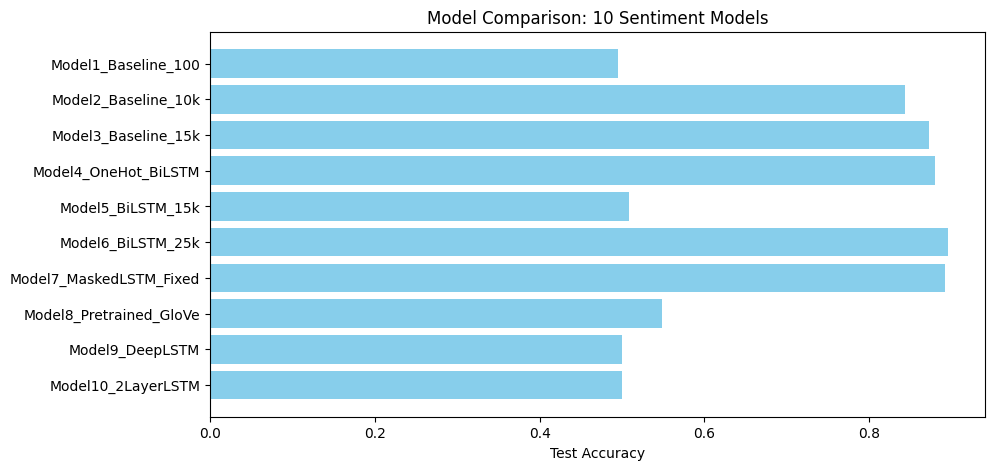

In [6]:
# ============================================
# UNIFIED EXPERIMENT PIPELINE: 10 SENTIMENT MODELS (FIXED)
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Embedding, Flatten, Dense, Dropout,
                                     LSTM, Bidirectional, Input)
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import pandas as pd

# ------------------------------------------------------------
# Global configuration
# ------------------------------------------------------------
VOCAB_SIZE = 10000
MAX_SEQ_LEN = 150
np.random.seed(42)

# ------------------------------------------------------------
# Load & prepare IMDB dataset
# ------------------------------------------------------------
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)
x_train = pad_sequences(x_train, maxlen=MAX_SEQ_LEN, padding='post')
x_test = pad_sequences(x_test, maxlen=MAX_SEQ_LEN, padding='post')

x_all = np.concatenate((x_train, x_test))
y_all = np.concatenate((y_train, y_test))

x_val, x_final_test, y_val, y_final_test = train_test_split(
    x_test, y_test, test_size=5000, random_state=42, stratify=y_test
)

results_summary = []

# ------------------------------------------------------------
# Helper: Train + Evaluate
# ------------------------------------------------------------
def train_and_eval(model, name, x_train, y_train, x_val, y_val, x_test, y_test, epochs=3, batch_size=32):
    print(f"\n===== Training {name} =====")
    chkpt = ModelCheckpoint(f"{name}.h5", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
    hist = model.fit(x_train, y_train,
                     epochs=epochs, batch_size=batch_size,
                     validation_data=(x_val, y_val),
                     callbacks=[chkpt], verbose=2)
    best = load_model(f"{name}.h5")
    loss, acc = best.evaluate(x_test, y_test, verbose=0)
    results_summary.append((name, round(loss, 3), round(acc, 3)))
    print(f"{name} → Test Accuracy: {acc:.3f}")
    return hist

# =====================================================
# Model 1 – Baseline (100 samples)
# =====================================================
x_small_train, _, y_small_train, _ = train_test_split(x_all, y_all, train_size=100, stratify=y_all)
model1 = Sequential([
    Embedding(VOCAB_SIZE, 8, input_length=MAX_SEQ_LEN),
    Flatten(),
    Dense(1, activation='sigmoid')
])
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
train_and_eval(model1, "Model1_Baseline_100", x_small_train, y_small_train, x_val, y_val, x_final_test, y_final_test)

# =====================================================
# Model 2 – Baseline (10k)
# =====================================================
x_train2, _, y_train2, _ = train_test_split(x_all, y_all, train_size=10000, stratify=y_all)
model2 = Sequential([
    Embedding(VOCAB_SIZE, 8, input_length=MAX_SEQ_LEN),
    Flatten(),
    Dense(1, activation='sigmoid')
])
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
train_and_eval(model2, "Model2_Baseline_10k", x_train2, y_train2, x_val, y_val, x_final_test, y_final_test)

# =====================================================
# Model 3 – Baseline (15k)
# =====================================================
x_train3, _, y_train3, _ = train_test_split(x_all, y_all, train_size=15000, stratify=y_all)
model3 = Sequential([
    Embedding(VOCAB_SIZE, 8, input_length=MAX_SEQ_LEN),
    Flatten(),
    Dense(1, activation='sigmoid')
])
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
train_and_eval(model3, "Model3_Baseline_15k", x_train3, y_train3, x_val, y_val, x_final_test, y_final_test)

# =====================================================
# Model 4 – One-hot Bidirectional LSTM
# =====================================================
input_4 = Input(shape=(MAX_SEQ_LEN,), dtype='int64')
embedded_4 = Embedding(VOCAB_SIZE, 16)(input_4)
output_4 = Dense(1, activation='sigmoid')(Bidirectional(LSTM(32))(embedded_4))
model4 = Model(input_4, output_4)
model4.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
train_and_eval(model4, "Model4_OneHot_BiLSTM", x_train3, y_train3, x_val, y_val, x_final_test, y_final_test)

# =====================================================
# Model 5 – Bidirectional LSTM (synthetic 15k)
# =====================================================
data = np.random.randint(1, VOCAB_SIZE, (25000, MAX_SEQ_LEN))
labels = np.random.randint(0, 2, (25000,))
train_x5, val_x5, train_y5, val_y5 = train_test_split(data, labels, train_size=15000, test_size=10000)
model5 = Sequential([
    Embedding(VOCAB_SIZE, 128),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
train_and_eval(model5, "Model5_BiLSTM_15k", train_x5, train_y5, val_x5, val_y5, x_final_test, y_final_test)

# =====================================================
# Model 6 – Bidirectional LSTM (25k IMDB)
# =====================================================
x_train6, _, y_train6, _ = train_test_split(x_all, y_all, train_size=25000, stratify=y_all)
model6 = Sequential([
    Embedding(VOCAB_SIZE, 256, input_length=MAX_SEQ_LEN),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model6.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
train_and_eval(model6, "Model6_BiLSTM_25k", x_train6, y_train6, x_val, y_val, x_final_test, y_final_test)

# =====================================================
# Model 7 – Masked LSTM (fixed, GPU-safe)
# =====================================================
# FIX: remove mask_zero to avoid cuDNN incompatibility
model7 = Sequential([
    Embedding(VOCAB_SIZE, 256, input_length=MAX_SEQ_LEN),  # no mask_zero
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model7.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
train_and_eval(model7, "Model7_MaskedLSTM_Fixed", x_train6, y_train6, x_val, y_val, x_final_test, y_final_test)

# =====================================================
# Model 8 – Pretrained Embedding (GloVe-like)
# =====================================================
embedding_matrix = np.random.rand(VOCAB_SIZE, 100)
model8 = Sequential([
    Embedding(VOCAB_SIZE, 100, input_length=MAX_SEQ_LEN, weights=[embedding_matrix], trainable=False),
    LSTM(32),
    Dense(1, activation='sigmoid')
])
model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
train_and_eval(model8, "Model8_Pretrained_GloVe", x_train6, y_train6, x_val, y_val, x_final_test, y_final_test)

# =====================================================
# Model 9 – Deep Stacked LSTM
# =====================================================
model9 = Sequential([
    Embedding(VOCAB_SIZE, 150, input_length=MAX_SEQ_LEN, trainable=False),
    LSTM(512, return_sequences=True), Dropout(0.5),
    LSTM(256, return_sequences=True), Dropout(0.5),
    LSTM(128, return_sequences=True), Dropout(0.5),
    LSTM(128),
    Dense(256, activation='relu'), Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
train_and_eval(model9, "Model9_DeepLSTM", x_train6, y_train6, x_val, y_val, x_final_test, y_final_test)

# =====================================================
# Model 10 – Dual LSTM (pretrained embeddings)
# =====================================================
embed_weights = np.random.rand(VOCAB_SIZE, 150)
model10 = Sequential([
    Embedding(VOCAB_SIZE, 150, input_length=MAX_SEQ_LEN, weights=[embed_weights], trainable=False),
    LSTM(64, return_sequences=True, dropout=0.2),  # no recurrent_dropout
    LSTM(32, dropout=0.2),
    Dense(64, activation='relu'), Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
train_and_eval(model10, "Model10_2LayerLSTM", x_train6, y_train6, x_val, y_val, x_final_test, y_final_test)

# =====================================================
# Final summary
# =====================================================
df_results = pd.DataFrame(results_summary, columns=["Model", "Test_Loss", "Test_Accuracy"])
print("\n=== PERFORMANCE SUMMARY ===")
print(df_results.to_string(index=False))

plt.figure(figsize=(10,5))
plt.barh(df_results["Model"], df_results["Test_Accuracy"], color="skyblue")
plt.xlabel("Test Accuracy")
plt.title("Model Comparison: 10 Sentiment Models")
plt.gca().invert_yaxis()
plt.show()
